In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from segger.prediction.predict_parquet import load_model, segment
from segger.training.segger_data_module import SeggerDataModule
from segger.data.parquet._utils import filter_transcripts, load_settings
from sg_utils.tl.phenograph_rapids import phenograph_rapids
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import *
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.utils import lighten_color

from matplotlib.colors import LinearSegmentedColormap, to_rgba
from requirements import *
from pathlib import Path
import celltypist as ct
import glob

## Run New Segmentation

## Transcripts to AnnData

In [12]:
# Filepaths
base_dir = Path((
    '/data/peer/moormana/GitHub/dpeerlab/segger_dev/dev/data/xenium_breast'
))
predictions_dir = base_dir

In [15]:
# Read in all transcripts
pattern = predictions_dir / '*/transcripts_df.parquet'
predictions_filepath = glob.glob(str(pattern))[0]
transcripts = pd.read_parquet(predictions_filepath)

In [ ]:
# Filter control probes and low QV probes
xe_settings = load_settings('xenium')

transcripts = filter_transcripts(
    transcripts,
    label=xe_settings.transcripts.label,
    filter_substrings=xe_settings.transcripts.filter_substrings,
    min_qv=30,
)

In [ ]:
# Convert to AnnData and preprocess
seg_col = 'segger_cell_id'
score_col = 'score'

# Subset Segger data to high-confidence transcripts
mask = ~transcripts[seg_col].isna()

# Transcripts to anndata
ad = anndata_from_transcripts(
    transcripts[mask],
    cell_label=seg_col,
    gene_label='feature_name',
    coordinate_labels=xe_settings.transcripts.xy,
)

# Add raw counts before filtering
ad.uns['raw_counts'] = dict(
    index=ad.obs.index.tolist(),
    count=ad.raw.X.A.sum(1),
)

In [13]:
# Preprocess
threshold = 10 #max(np.quantile(ad.uns['raw_counts']['count'], 0.05), 5)
preprocess_rapids(
    ad,
    filter_min_counts=threshold,
    pca_total_var=0.75,
    umap_min_dist=0.25,
    umap_n_epochs=2000,
    pca_layer='lognorm',
    knn_neighbors=20,
    phenograph_resolution=1,
)

# Save to file
ad.write_h5ad(predictions_dir / f'{uid}.h5ad')

Done: 100%|██████████| 6/6 [07:55<00:00, 79.21s/it]         


In [14]:
ct_model = ct.Model.load(str(data_dir / 'NSCLC_celltypist_model.pkl'))

# Read in AnnData
filepath = predictions_dir / f'{uid}.h5ad'
ad = sc.read_h5ad(filepath)

# Re-normalize consistent with CellTypist model
ad.layers['norm_1k'] = ad.raw.X.copy()
sc.pp.normalize_total(ad, layer='norm_1k', target_sum=1e2)
ad.layers['lognorm_1k'] = ad.layers['norm_1k'].copy()
if 'log1p' in ad.uns: del ad.uns['log1p']
sc.pp.log1p(ad, layer='lognorm_1k')

phenograph_rapids(ad, min_size=1, resolution=1)

# Cell type
with HiddenPrints():
    ad.X = ad.layers['lognorm_1k']
    preds = ct.annotate(
        ad, model=ct_model, majority_voting=True,
        over_clustering='phenograph_cluster',
        min_prop=0.5,
    )

# Label AnnData
ad.obs['celltypist_label'] = preds.predicted_labels['predicted_labels']
ad.obs['celltypist_label_cluster'] = preds.predicted_labels['majority_voting']
ad.obs['celltypist_probability'] = preds.probability_matrix.max(1)
for col in preds.probability_matrix.columns:
    ad.obs[f'{col} Probability'] = preds.probability_matrix[col]
entropy = sp.stats.entropy(preds.probability_matrix, axis=1)
ad.obs['celltypist_entropy'] = entropy

# Cleanup
del ad.layers['lognorm_1k'], ad.layers['norm_1k']

ad.write_h5ad(filepath)

In [15]:
ad_seg = ad

In [16]:
ad_bay = sc.read_h5ad(data_dir / f'h5ads/baysor_cell_id_c=0.5.h5ad')

### Histograms of Cell UMI Counts

In [44]:
# Cutoff of cells below IQR
iqr_cutoff = 0.25

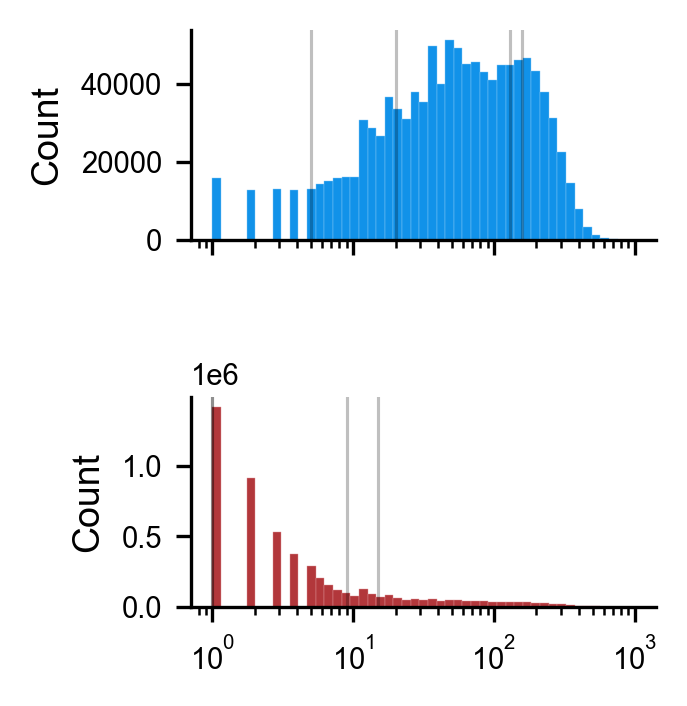

In [65]:
fig, axes = plt.subplots(
    2, 1, figsize=(2, 2.5), 
    gridspec_kw=dict(hspace=0.75),
    sharex=True, sharey=False,
)

colors = [named_colors['Baysor, c=0.5'], named_colors['segger+']]

for ax, ad, color in zip(axes.flat, [ad_bay, ad_seg], colors):  
    counts = ad.uns['raw_counts']['count']  # unfiltered counts
    
    sns.histplot(
        data=counts,
        bins=np.linspace(0, 3, 50),
        facecolor=color,
        edgecolor=lighten_color(color, 0.5),
        linewidth=0.1,
        log_scale=(True, False),
        ax=ax,
    )
    # Draw filtering and IQR cutoffs
    for q in [0.05, 0.25, 0.75, 0.8125]:
        ax.axvline(np.quantile(counts, q), lw=0.75, color='k', alpha=0.25)

fig.savefig(media_dir / 'cc_test_oversegmentation_umi_histograms.svg')

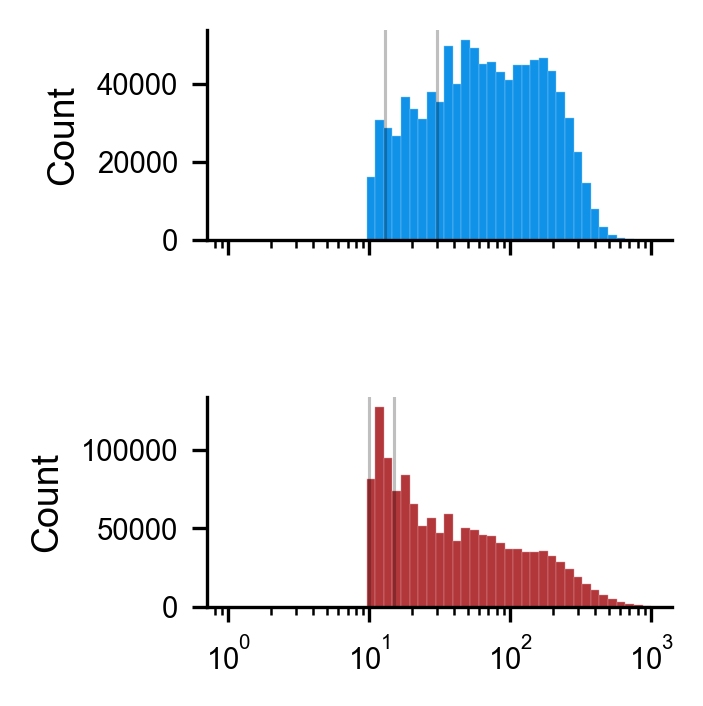

In [46]:
fig, axes = plt.subplots(
    2, 1, figsize=(2, 2.5), 
    gridspec_kw=dict(hspace=0.75),
    sharex=True, sharey=False,
)

colors = [named_colors['Baysor, c=0.5'], named_colors['segger+']]

for ax, ad, color in zip(axes.flat, [ad_bay, ad_seg], colors):  
    counts = ad.uns['raw_counts']['count']  # unfiltered counts
    counts = counts[counts > 10]
    
    sns.histplot(
        data=counts,
        bins=np.linspace(0, 3, 50),
        facecolor=color,
        edgecolor=lighten_color(color, 0.5),
        linewidth=0.1,
        log_scale=(True, False),
        ax=ax,
    )
    # Draw filtering and IQR cutoffs
    for q in [0.05, iqr_cutoff]:
        ax.axvline(np.quantile(counts, q), lw=0.75, color='k', alpha=0.25)

fig.savefig(media_dir / 'cc_test_oversegmentation_umi_histograms_filtered.svg')

### Violin Plots of Cell Entropies by UMI Counts

In [47]:
# Add column to plot
for ad in [ad_bay, ad_seg]:
    counts = ad.uns['raw_counts']['count']
    bin_edges = np.quantile(counts[counts >= 10], [0, iqr_cutoff, 1])
    ad.obs['counts_group'] = pd.cut(ad.obs['n_counts'], bins=bin_edges)

In [48]:
# Corresponding palette
colors = sns.color_palette('tab20')
palette = [colors[0], colors[-1]]

In [49]:
# Clip to ignore outliers
lbl = 'celltypist_label'
col = 'celltypist_entropy'
vmin = min(ad_bay.obs[col].quantile(0.001), ad_seg.obs[col].quantile(0.001))
vmax = min(ad_bay.obs[col].quantile(0.99), ad_seg.obs[col].quantile(0.99))

# Create continuous labeling
categories = set(ad_bay.obs[lbl].unique()).union(ad_seg.obs[lbl].unique())
mapping = {k: v * 2 for v, k in enumerate(categories)}
new_col = 'continuous_label'

ad_bay.obs[new_col] = ad_bay.obs[lbl].map(mapping).astype(float)
vals = (ad_bay.obs[col].clip(vmin, vmax) - vmin) / (vmax - vmin)
ad_bay.obs[new_col] += vals
ad_bay.obs[new_col] /= len(categories) * 2 - 1

ad_seg.obs[new_col] = ad_seg.obs[lbl].map(mapping).astype(float)
vals = (ad_seg.obs[col].clip(vmin, vmax) - vmin) / (vmax - vmin)
ad_seg.obs[new_col] += vals
ad_seg.obs[new_col] /= len(categories) * 2 - 1

# Create corresponding colormap
colors = [c for cat in categories for c in (named_colors[cat], 'lightgray')]
cmap = LinearSegmentedColormap.from_list('', colors, 255)

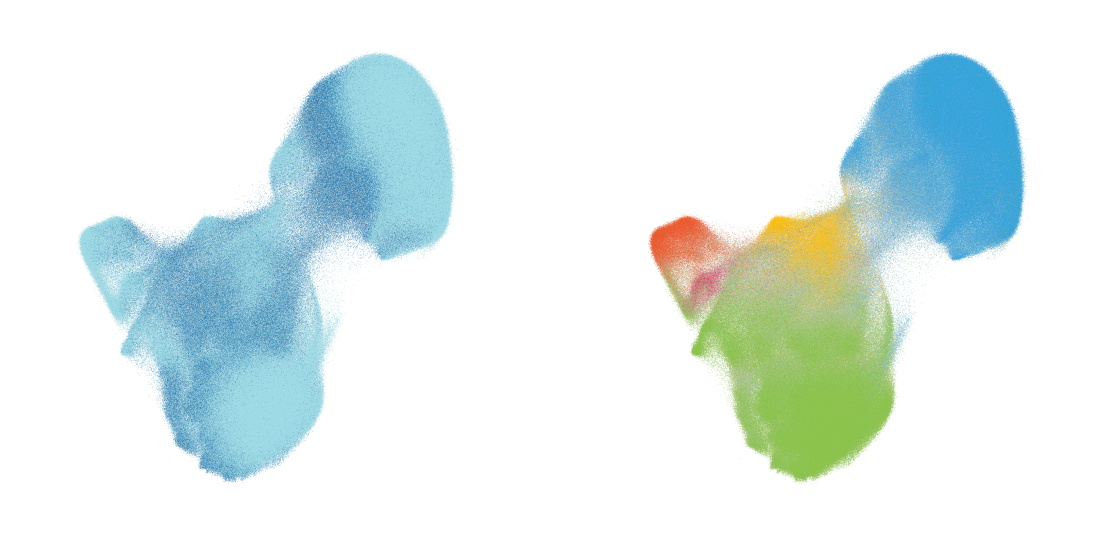

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.25))

styles = dict(
    s=0.05, sort_order=False, legend_loc='', colorbar_loc=None,
    rasterized=True,
)
# UMI count group
_ = plot_embedding(ad_seg, 'counts_group', ax=axes[0], palette=palette, **styles)
# Cell type labels
_ = plot_embedding(ad_seg, new_col, cmap=cmap, ax=axes[1], **styles)
for ax in axes:
    ax.set_title('')

fig.savefig(media_dir / 'cc_test_oversegmentation_segger_umaps.svg', dpi=400)

## Cell Type Proportions

### Overall

In [56]:
ad_cps = sc.read_h5ad(data_dir / f'h5ads/cellpose_cell_id.h5ad')

In [59]:
counts = pd.DataFrame(
    index=['Cellpose', 'segger+', 'Baysor, c=0.5'],
    dtype=float,
)
for name, ad in zip(counts.index, [ad_cps, ad_seg, ad_bay]):
    mask = ad.obs['celltypist_probability'].ge(0.5)
    vals = ad.obs[mask].value_counts('celltypist_label')
    counts.loc[name, vals.index] = vals

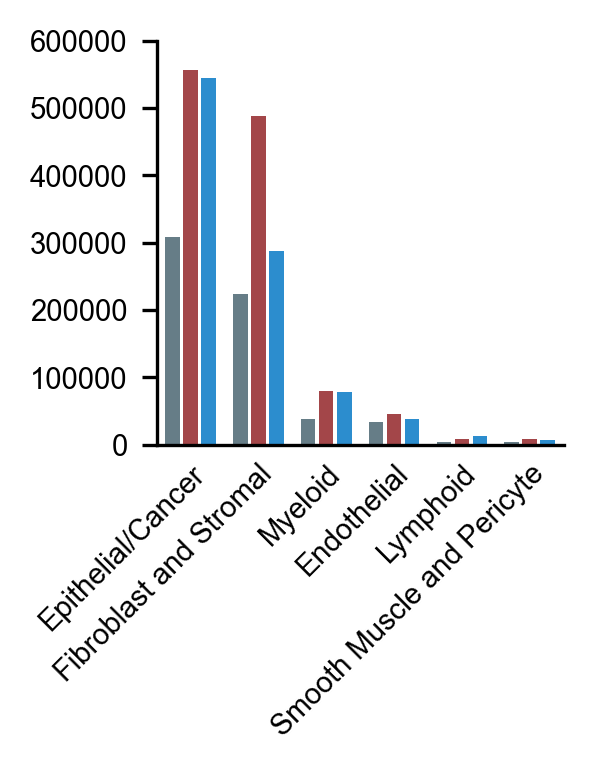

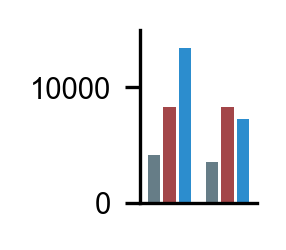

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.75))
kwargs = dict(x='variable', hue='seg', y='value', gap=0.2, palette=named_colors)
df = counts.copy()
df['seg'] = df.index
df = df.melt(id_vars=['seg'])
sns.barplot(df, ax=ax, legend=False, **kwargs)
ax.set_ylim(0, 600000)
ax.tick_params(axis='x', length=0)
ax.set_xticklabels(ax.get_xticklabels(), ha='right', va='top', rotation=45, rotation_mode="anchor")
ax.set_ylabel('')
ax.set_xlabel('')
fig.savefig(media_dir / 'oversegmentation_cell_type_proportions.svg')

fig, ax_inset = plt.subplots(1, 1, figsize=(0.5, 0.75))
mask = df['variable'].isin(['Lymphoid', 'Smooth Muscle and Pericyte'])
sns.barplot(df[mask], ax=ax_inset, legend=False, **kwargs)
ax_inset.set_ylim(0, 15000)
ax_inset.set_ylabel('')
ax_inset.xaxis.set_visible(False)
fig.savefig(media_dir / 'cc_test_oversegmentation_cell_type_proportions_inset.svg')